# Part 1: Visual Odometry

In this notebook, we explore the first steps of visual slam through code and low-level explanation 



The first step in most computer vision tasks is identifying features to be used for further processing. To identify features, we have to know what they are and what type of features are best. In this notebook, we focus on only the code. A more detailed explanation can be found in the readme document.

## Library imports

In [4]:
# from utils import edge_detection_gradient, edge_detection_laplace
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Features - Edges

### Gradient Based Edges

In [2]:
edge_img_grad, img = edge_detection_gradient("./assets/images/banner3.jpg", smooth=True)

[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]
(3, 3)
(3, 3)


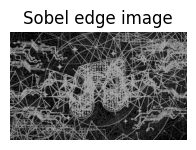

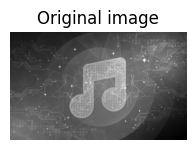

In [3]:
plt.figure(figsize=(5, 4))

plt.subplot(121)
plt.imshow(edge_img_grad, cmap='gray')
plt.title('Sobel edge image')
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 4))
plt.subplot(122)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

### Laplace based edges (second derivative edge detection)

In [4]:
laplace_img, img = edge_detection_laplace("./assets/images/banner3.jpg", "laplace", smooth=True)

[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]


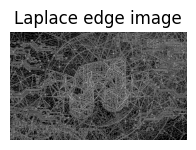

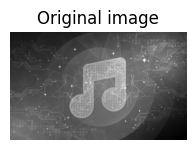

In [5]:
plt.figure(figsize=(5, 4))

plt.subplot(121)
plt.imshow(laplace_img, cmap='gray')
plt.title('Laplace edge image')
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 4))
plt.subplot(122)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

Other methods for finding edges include fourier, etc

## Keypoint detection & Matching

In this section, we perform feature extraction and matching. In the previous section we learned that features are the building blocks of images (images are made up of several features) and they include edges, corners, blobs, etc. However, edges and corners are not exciting or distinctive enough for identifying images, hence we resort to **Interest Points** (More can be found in the readme of this folder.)

Several algorithms can be used to find these interest points. We use the ***SIFT*** feature detector for demonstration. The explanations as well as other feature detection methods are found in the readme too.

In [5]:
# SIFT Feature
img = cv2.imread('anime_gal.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Adding Scale
img_ = cv2.pyrDown(cv2.pyrDown(img))

# Adding Rotation
num_rows, num_cols = img_.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
img_ = cv2.warpAffine(img_, rotation_matrix, (num_cols, num_rows))
img_gray_ = cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY)

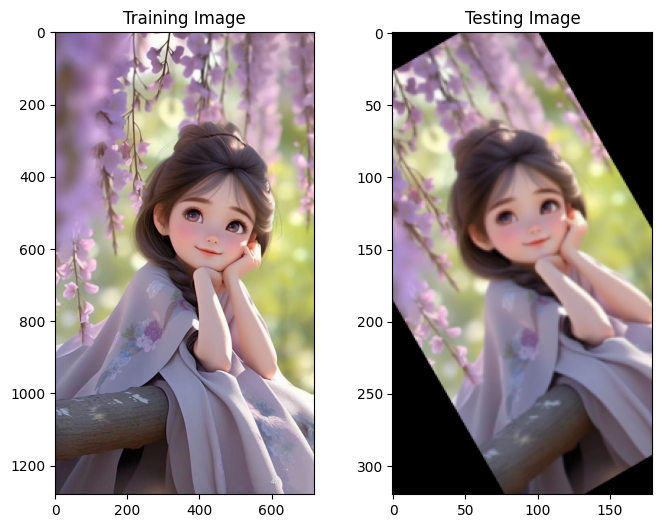

In [6]:
fx, plots = plt.subplots(1, 2, figsize=(8,6))
plots[0].set_title("Training Image")
plots[0].imshow(img)
plots[1].set_title("Testing Image")
plots[1].imshow(img_)

### Keypoint detection using SIFT

Number of Keypoints Detected In The Training Image:  1371
Number of Keypoints Detected In The Query Image:  303


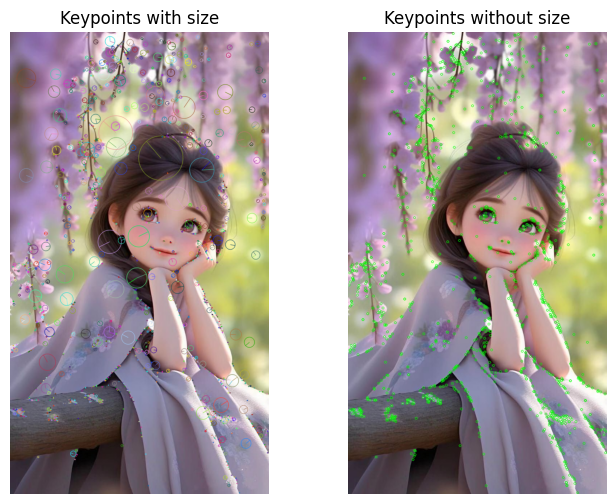

In [7]:
# Computing Sift
sift = cv2.SIFT_create()
kp, descriptor = sift.detectAndCompute(img_gray, None)
kp_, descriptor_ = sift.detectAndCompute(img_gray_, None)

kp_sizeless = np.copy(img)
kp_size = np.copy(img)

cv2.drawKeypoints(img, kp, kp_sizeless, color = (0, 255, 0))
cv2.drawKeypoints(img, kp, kp_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1, 2, figsize=(8,6))
plots[0].set_title("Keypoints with size")
plots[0].imshow(kp_size, cmap='gray')
plots[0].axis('off')

plots[1].set_title("Keypoints without size")
plots[1].imshow(kp_sizeless, cmap='gray')
plots[1].axis('off')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(kp))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(kp_))

### Keypoint matching - Brute Force

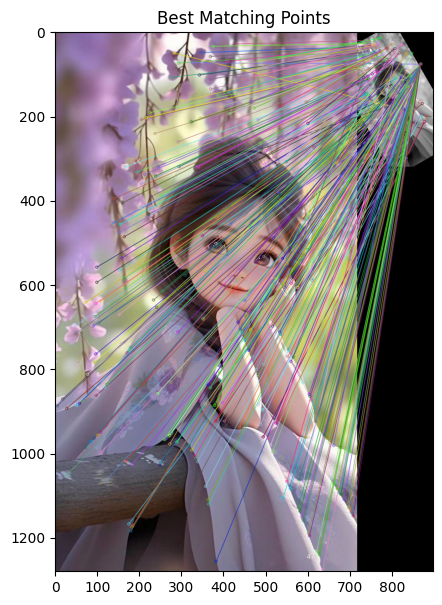


Number of Matching Keypoints Between The Training and Query Images:  286


In [9]:
# matching keypoints
# brute force
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

matches = bf.knnMatch(descriptor, descriptor_, k=2)
# matches = sorted(matches, key = lambda x : x.distance)
ratio_thresh = 0.75
good_matches = [m for m, n in matches if m.distance < ratio_thresh * n.distance]

# result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)
result = cv2.drawMatches(img, kp, img_gray_, kp_, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(good_matches))


### Keypoint matching - FLANN

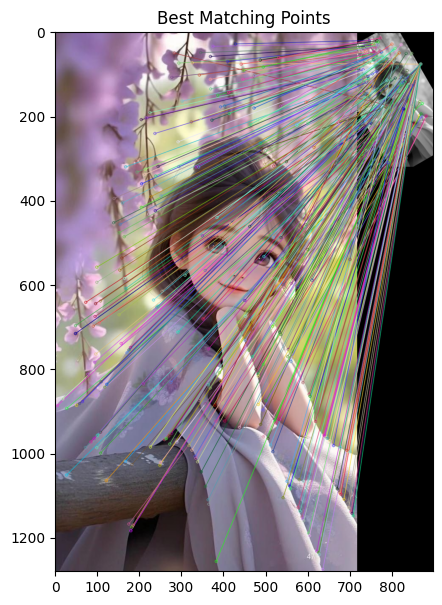


Number of Matching Keypoints Between The Training and Query Images:  1371


In [10]:
# flann method (matching)

index_params = dict(algorithm=1, trees=5)  # FLANN_INDEX_KDTREE
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptor, descriptor_, k=2)

# Sort matches by distance
# matches = sorted(matches, key=lambda x: x.distance)
# print()
result = cv2.drawMatches(img, kp, img_gray_, kp_, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

We're officially done with the detection and matching! For more information check out the readme document in the folder.

Now we move up to outlier detection

## Outlier Rejection

We have obtained the keypoints using the SIFT algorithm and have obtained matches between two images using both flann and brute force (optimizing with k-nn). 
Our next concern is that some of the keypoints we choose, albeit correct matches according to its signature, are not in fact geometrically correct. So we move on to the problem of rejecting those geometrically incorrect ones. This process is known as outlier rejection.

A very popular algorithm for outlier rejection is the RANSAC algorithm. We will implement this in the subsequent cells.

### RANSAC algorithm

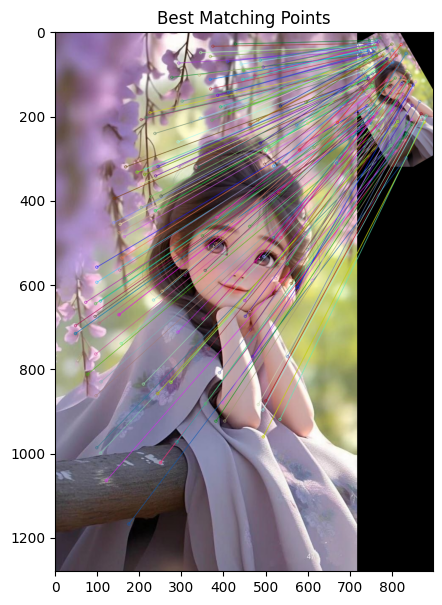

number of good matches: 286
number of inliers: 158


In [11]:
src_pts = np.float32([kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts ,cv2.RANSAC, 5)
matches_mask = mask.ravel().tolist()
inliers = [good_matches[i] for i in range(len(good_matches)) if matches_mask[i]]

result = cv2.drawMatches(img, kp, img_, kp_, inliers, None, 
                            #   matchColor=(0, 255, 0),  # Green for inliers
                              singlePointColor=None, 
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

print(f"number of good matches: {len(good_matches)}")
print(f"number of inliers: {len(inliers)}")


Now that outlier rejection is done, we estimate the flow of the features from one frame to the other using ( how the feature has moved over time across frames )
this step is called Optical Flow Estimation

## Motion Estimation

The next step is to estimate the motion of the keypoints across multiple successive frames. There are several methods for this but in this notebook, and in for this vslam steps, we both the Epipolar geometry and the perspective-n-point method. 

### Epipolar Geometry

fancy description coming soon but this can be used when we have 2d features and not depth information. It's similar to the homography computation butt we make use of the camera intrinsic matix K. The code is shown below.


#### camera calibration
This step can be skipped if you have the camera's intrinsic matrix.



def calibrate_camera():
    

In [12]:
def calibrate_camera(image_paths, checkerboard_size=(6,9), square_size=1.0):
    objp = np.zeros((checkerboard_size[0]*checkerboard_size[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1,2)
    objp*= square_size
    
    objpoints = []
    imgpoints= []

    for img_path in image_paths:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return K, dist


since we do not have k right now, we can use fundamental matrix, but only for testing this out.

In [14]:
pts1 = np.float32([kp[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp_[m.trainIdx].pt for m in good_matches])
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC, 1.0) 
E, mask = cv2.findEssentialMat(pts1, pts2, F, method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, F)

till next time